## Download the Mnist dataset as a tensor

In [10]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.MNIST(
    root="data", train=True, download=True, transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

## Prepare our data and make it iterable:

Feature batch shape (NCHW): torch.Size([128, 1, 28, 28])
Labels batch shape: torch.Size([128])


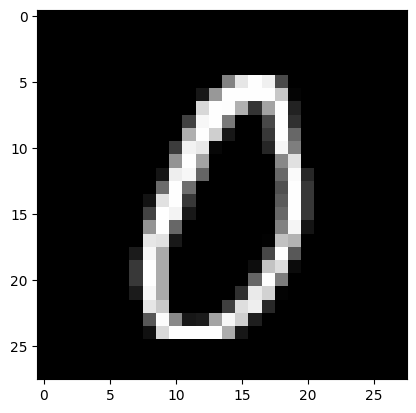

Label: 0


In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape (NCHW): {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Making sure we are using the GPU:

In [12]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Building and visualizing our CNN:

In [13]:
import os
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_pool_relu_stack = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=3, padding="valid"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
            nn.Conv2d(1, 1, kernel_size=3, padding="valid"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
            nn.Flatten(),
            nn.Linear(400, 10),
            nn.Flatten(),
        )

    def forward(self, x):
        logits = self.conv_pool_relu_stack(x)
        # proba = nn.Softmax(1)(logits)
        return logits


model = CNN().to(device)

### Testing without any training our model:

In [14]:
X = torch.rand(1, 28, 28, device=device)
proba = model(X)
print(f"Shape of the logits : {proba.shape}")

Shape of the logits : torch.Size([1, 10])


### How big is our model and what is it's structure?

In [15]:
print(f"Model structure: {model}\n\n")

nbr_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"We have {nbr_params} trainable parameters in our model")

Model structure: CNN(
  (conv_pool_relu_stack): Sequential(
    (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=10, bias=True)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
)


We have 4030 trainable parameters in our model


## Optimization hyperparameters:

In [16]:
learning_rate = 1e-3
batch_size = 128
epochs = 40
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Training loop

In [17]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, Y) in enumerate(dataloader):
        # Compute prediction and loss
        x = X.to(device=device)
        y = Y.to(device=device)
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, Y in dataloader:
            x = X.to(device=device)
            y = Y.to(device=device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

## Actual training:

In [18]:

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.296921  [  128/60000]
loss: 2.295914  [12928/60000]
loss: 2.284094  [25728/60000]
loss: 2.264377  [38528/60000]
loss: 2.267117  [51328/60000]
Test Error: 
 Accuracy: 27.0%, Avg loss: 2.267086 

Epoch 2
-------------------------------
loss: 2.270940  [  128/60000]
loss: 2.250805  [12928/60000]
loss: 2.248779  [25728/60000]
loss: 2.248131  [38528/60000]
loss: 2.230788  [51328/60000]
Test Error: 
 Accuracy: 35.9%, Avg loss: 2.208604 

Epoch 3
-------------------------------
loss: 2.199913  [  128/60000]
loss: 2.173604  [12928/60000]
loss: 2.153025  [25728/60000]
loss: 2.108766  [38528/60000]
loss: 2.043384  [51328/60000]
Test Error: 
 Accuracy: 50.2%, Avg loss: 1.985860 

Epoch 4
-------------------------------
loss: 1.983215  [  128/60000]
loss: 1.885151  [12928/60000]
loss: 1.717968  [25728/60000]
loss: 1.517907  [38528/60000]
loss: 1.263749  [51328/60000]
Test Error: 
 Accuracy: 68.5%, Avg loss: 1.150112 

Epoch 5
------------------------

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.330977 

Epoch 35
-------------------------------
loss: 0.292804  [  128/60000]
loss: 0.262978  [12928/60000]
loss: 0.243052  [25728/60000]
loss: 0.240244  [38528/60000]
loss: 0.321087  [51328/60000]
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.341961 

Epoch 36
-------------------------------
loss: 0.382099  [  128/60000]
loss: 0.241547  [12928/60000]
loss: 0.291310  [25728/60000]
loss: 0.395815  [38528/60000]
loss: 0.389853  [51328/60000]
Test Error: 
 Accuracy: 90.4%, Avg loss: 0.332512 

Epoch 37
-------------------------------
loss: 0.437398  [  128/60000]
loss: 0.240502  [12928/60000]
loss: 0.314072  [25728/60000]
loss: 0.363133  [38528/60000]
loss: 0.344354  [51328/60000]
Test Error: 
 Accuracy: 90.4%, Avg loss: 0.326949 

Epoch 38
-------------------------------
loss: 0.441747  [  128/60000]
loss: 0.206387  [12928/60000]
loss: 0.294218  [25728/60000]
loss: 0.349403  [38528/60000]
loss: 0.339418  [51328/60000]
Test Error: 
 Accuracy: 90.2